In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from glob import glob
from scipy import stats
from scipy.stats import pearsonr, levene
import os

In [ ]:
pheno_cols = ["ADP"]
EUR_path_interval = "%s/genetic_score/EUR_interval" % export_folder
EUR_path = "%s/genetic_score/EUR" % export_folder
tag = "29_sept"

# Manhattan plot

In [ ]:
gws = []
#for c in tqdm(pheno_cols):
for c in tqdm(pheno_cols):
    gw = pd.read_csv("%s/%s/bolt_res_feb_%s" % (export_folder,tag,c),sep="\t")
    gw["pheno"] = c
    gw.P_BOLT_LMM = gw.P_BOLT_LMM.astype(float)
    gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)
gw.rename(columns={"P_BOLT_LMM":"P"},inplace=True)

In [ ]:
gw["POS"] = gw["BP"]
for ch in range(1,23):
    gw.loc[gw.CHR > ch,"POS"] += gw.loc[gw.CHR == ch,"BP"].max()
gw_ = gw.loc[gw.P < 1e-3]

In [ ]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

gw_["IN_UKBB"] = gw_.SNP.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

# Select significant SNPs

## Prepare

In [ ]:
cov = pd.read_csv("%s/%s/covars.csv" % (export_folder, tag), sep="\t")
phenotypes = pd.read_csv("%s/%s/phenotypes.csv" % (export_folder, tag), sep="\t")

phenotypes["ID"] = phenotypes["FID"].astype(str) + "_" + phenotypes["IID"].astype(str)
phenotypes = phenotypes.set_index("ID")[pheno_cols]

cov["ID"] = cov["FID"].astype(str) + "_" + cov["IID"].astype(str)
covar_cols = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PLT","MPV","IPF","PCT","PDW","SEX","age_covar","cohort_covar"]
cov = cov.set_index("ID")[covar_cols]

X = pd.merge(cov,phenotypes,left_index=True,right_index=True)

## Utils

In [8]:
def get_p_value(source,target):
    lm = LinearRegression().fit(source,target)
    return pearsonr(target,lm.predict(source))[1]

In [9]:
def compare_p_values(X,model,augmented_model,Y):
    lm1 = LinearRegression().fit(X[model],Y)
    lm2 = LinearRegression().fit(X[augmented_model],Y)
    
    fit_1 = lm1.predict(X[model])
    fit_2 = lm2.predict(X[augmented_model])
    
    #residuals_1 = Y-fit_1
    #residuals_2 = Y-fit_2
    
    #p_val = levene(residuals_1,residuals_2,center="mean")[1]
    p_val = levene(fit_1,fit_2,center="mean")[1]
    
    return p_val

## Run

In [10]:
max_distance = 5e6 # from Dragana's
significant_SNPs = {}
P_threshold = 1e-8
genotypes = {}
for c in pheno_cols:
    print("Starting causal SNPs extraction")
    print(c)
    significant_SNPs[c] = []
    d = gw_.loc[gw_.pheno == c]
    hits = d.loc[(d.P < P_threshold) & (d.IN_UKBB)].copy()
    hits["region"] = AgglomerativeClustering(n_clusters=None,distance_threshold=max_distance,linkage="single")\
                        .fit(np.reshape(hits.POS.values,(-1,1)))\
                        .labels_
    for region, h in hits.groupby("region"):
        print("Region %d" % region)
        #if h.shape[0] == 1:
        #    significant_SNPs[c].append(h["SNP"].iloc[0])
        #    continue
        
        # Write the list of SNPS to a file
        SNP_list_file = "%s/conditional_analysis/significant_snps_%s_%s.txt" % (export_folder,c, tag)
        with open(SNP_list_file,"w") as file:
            for s in h.SNP.tolist():
                file.write("%s\n" % s)
        
        # Extract the table
        ch = int(h.CHR.iloc[0])
        gen_path = "%s/conditional_analysis/genotypes_region_%d_%s_CHR_%d" % (export_folder, region, c, ch)
        command = "/home/hv270/plink"
        command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % ch
        command += " --extract %s" % SNP_list_file
        command += " --keep %s" % EUR_path_interval
        command += " --recode A-transpose --out %s" % gen_path
        p = subprocess.Popen(command,shell=True)
        p.wait()
        print("Done exporting genotypes")
        df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
        df = df.set_index("SNP")
        ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
        df = df[ID_cols].T
        var_cols = df.columns
        
        for var in var_cols:
            df.loc[df[var].isnull(),var] = df.loc[~df[var].isnull(),var].mean()
        
        G_X = pd.merge(df,X.copy(),left_index=True,right_index=True)
        
        G = G_X[var_cols]
        C = G_X[covar_cols]
        Y = G_X[[c]]
        
        # Adjust phenotype by covariates
        lm_covars = LinearRegression().fit(C,Y)
        Y[c] = Y[c] - lm_covars.predict(C)[:,0]
        
        univariable_p_values = [pearsonr(G[snp],Y[c])[1] for snp in G.columns]
        G = G[[G.columns[i] for i in np.argsort(univariable_p_values)]]
        
        model = [G.columns[0]]
        vars_not_in_model = lambda : [v for v in G.columns if v not in model]
        
        while True and (len(vars_not_in_model()) > 0):
            # Augment the model
            addition_p_values = pd.Series(index=vars_not_in_model(),dtype=float)
            for s in addition_p_values.index:
                #print("Trying to add %s" % s)
                LD = False
                for m in model:
                    R_2 = pearsonr(G[m],G[s])[0]**2
                    if R_2 >= 0.9:
                        addition_p_values.loc[s] = 1.
                        LD = True
                if LD: continue
                augmented_model = model + [s]
                addition_p_values.loc[s] = compare_p_values(G,model,augmented_model,Y[c])
            if addition_p_values.min() >= P_threshold:
                #print("Nothing to add, keep %s" % (model))
                break
            else:
                #print("Adding %s" % s)
                model.append(addition_p_values.sort_values().index[0])
            
            # Reduce the model
            reduce = True
            while reduce:
                reduce = False
                removal_p_values = pd.Series(index=model,dtype=float)
                for s in removal_p_values.index:
                    #print("Trying to remove %s" % s)
                    reduced_model = [m for m in model if m != s]
                    removal_p_values.loc[s] = compare_p_values(G,model,reduced_model,Y[c])
                if removal_p_values.min() <= P_threshold:
                    pass
                    # Go to augment
                else:
                    to_remove = removal_p_values.sort_values().index[-1]
                    print("Removing %s" % to_remove)
                    model = [m for m in model if m != to_remove]
                    reduce = True if len(model) >= 2 else False
                    # Go to reduce
        
        significant_SNPs[c] += model
        
        print("Done causal variant extraction. Kept %d out of %d" % (len(model),len(var_cols)))
        print("Hit : ")
        print(h.loc[h.SNP.isin(model),["CHR","BP","SNP","P"]])
        
        genotypes[(c, region)] = G[model]
    

Starting causal SNPs extraction
ADP
Region 0
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 139
Hit : 
         CHR         BP         SNP             P
3213367    5  131600187  rs13357280  2.700000e-14
3213455    5  131625420   rs2087097  3.000000e-09
Region 1
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 3 out of 410
Hit : 
        CHR         BP         SNP             P
697374    1  247719769  rs56043070  5.100000e-26
698803    1  248010949  rs60726644  1.500000e-12
698958    1  248039294   rs1339847  5.400000e-60
Region 2
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 219
Hit : 
         CHR         BP         SNP             P
6725362   12  122247114  rs77408535  5.700000e-20
6725700   12  122365583   rs7961894  4.200000e-69
Region 3
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 16
Hit : 
         CHR         BP        SNP             P
4897310    8  106583124  rs4734879  7.800000e-11
Region 4
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 129
Hit : 
         CHR         BP        SNP             P
1081867    2  121053244  rs6739106  7.000000e-18
Region 5
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 80
Hit : 
         CHR        BP         SNP             P
8027175   17  33864771   rs8082605  2.600000e-15
8027822   17  34032877  rs74981786  7.200000e-09
Region 6
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 159
Hit : 
         CHR        BP         SNP             P
5639710   10  65066186  rs10761741  1.500000e-14
Region 7
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 274
Hit : 
         CHR        BP       SNP    P
8813355   20  57597971  rs415064  0.0
Region 8
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 51
Hit : 
         CHR         BP         SNP             P
1402831    2  225751613  rs10164672  3.200000e-12
Region 9
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 2
Hit : 
        CHR         BP        SNP             P
446367    1  171947018  rs2180748  2.400000e-09
Region 10
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 16
Hit : 
         CHR        BP         SNP             P
5279289    9  99087217  rs58088508  1.100000e-13
Region 11
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 10
Hit : 
         CHR       BP         SNP             P
5429660   10  3102695  rs12250755  3.400000e-11
5429687   10  3106857   rs7923030  2.300000e-10
Region 12
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 3
Hit : 
         CHR         BP         SNP             P
1384524    2  220096122  rs79013471  1.800000e-09
Region 13
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 11
Hit : 
        CHR         BP        SNP             P
551345    1  205240145  rs1768584  7.800000e-10
Region 14
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 120
Hit : 
         CHR        BP        SNP             P
8620574   19  55538980  rs1654425  4.000000e-24
Region 15
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 28
Hit : 
         CHR        BP         SNP             P
3013603    5  72023874  rs34744010  1.400000e-09
Region 16
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 42
Hit : 
       CHR        BP         SNP             P
33038    1  10271688  rs11121529  9.400000e-14
Region 17
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 161
Hit : 
         CHR        BP        SNP             P
1657326    3  56809820  rs9880418  7.700000e-14
1657453    3  56849749  rs1354034  1.200000e-90
Region 18
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 7
Hit : 
         CHR       BP        SNP             P
7946018   17  3816961  rs7207182  4.100000e-09
Region 19
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR        BP         SNP             P
7275955   14  70653758  rs61978213  6.000000e-13
Region 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR         BP         SNP             P
5329368    9  113312231  rs61751937  3.600000e-09
Region 21
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 2
Hit : 
         CHR      BP        SNP             P
5029121    9  273178  rs3215853  2.900000e-10
Region 22
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 2
Hit : 
        CHR         BP         SNP             P
392801    1  156869047  rs12566888  2.400000e-10
Region 23
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 3 out of 46
Hit : 
         CHR        BP         SNP             P
7888352   16  81870969  rs12445050  1.100000e-14
7888386   16  81876238  rs62045701  5.500000e-12
7888472   16  81886135   rs7188868  1.200000e-13
Region 24
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 2 out of 224
Hit : 
         CHR        BP        SNP             P
8010156   17  27699779  rs7216124  2.800000e-29
8010583   17  27876561  rs2559619  7.200000e-20
Region 25
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 73
Hit : 
         CHR      BP        SNP             P
5877013   11  201584  rs1976848  8.200000e-28


In [12]:
all_significant_SNPs = []
for c in significant_SNPs:
    all_significant_SNPs += significant_SNPs[c]
all_significant_SNPs = list(set(all_significant_SNPs))
recap = pd.DataFrame(index=all_significant_SNPs)
for c in pheno_cols:
    recap["causal_%s" % c] = recap.index.isin(significant_SNPs[c])


In [13]:
for c in pheno_cols:
    recap = pd.merge(recap,
                     gw.loc[gw.pheno == c,["SNP","BETA","P"]].set_index("SNP").rename(columns={"BETA":"BETA_%s" % c,
                                                                                               "P":"P_%s" % c}),
                     left_index=True,right_index=True)
recap = pd.merge(recap,gw.loc[gw.pheno == pheno_cols[0],["SNP","A1FREQ","CHR","BP"]].set_index("SNP"),left_index=True,right_index=True)

## Export

In [14]:
for c in pheno_cols:
    path = "%s/conditional_analysis/causal_SNPs_%s_%s.txt" % (export_folder,tag,c)
    with open(path,"w") as f:
        for snp in significant_SNPs[c]:
            f.write("%s\n" % snp)

In [15]:
path = "%s/conditional_analysis/causal_SNPs_%s_all.txt" % (export_folder,tag)
with open(path,"w") as f:
    for snp in all_significant_SNPs:
        f.write("%s\n" % snp)

# Comparison w/ Dragana's GWAS

In [16]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [17]:
for CH in range(1,23):
    # Write the list of SNPS to a file
    SNP_list_file = "%s/conditional_analysis/dragana_snps_chr_%d.txt" % (export_folder, CH)
    SNP_list = dgw.loc[(dgw["Chr (GRCh37)"] == CH) & dgw.SNP.str.contains("rs")].SNP.unique().tolist()
    SNP_list = [s for s in SNP_list if "rs" in s]
    with open(SNP_list_file,"w") as file:
        for s in SNP_list:
            file.write("%s\n" % s)

    # Extract the table
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    command = "/home/hv270/plink"
    command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % CH
    command += " --extract %s" % SNP_list_file
    command += " --keep %s" % EUR_path_interval
    command += " --recode A-transpose --out %s" % gen_path
    p = subprocess.Popen(command,shell=True)
    p.wait()
    print("Done exporting genotypes of chrom %d" % CH)

Done exporting genotypes of chrom 1
Done exporting genotypes of chrom 2
Done exporting genotypes of chrom 3
Done exporting genotypes of chrom 4
Done exporting genotypes of chrom 5
Done exporting genotypes of chrom 6
Done exporting genotypes of chrom 7
Done exporting genotypes of chrom 8
Done exporting genotypes of chrom 9
Done exporting genotypes of chrom 10
Done exporting genotypes of chrom 11
Done exporting genotypes of chrom 12
Done exporting genotypes of chrom 13
Done exporting genotypes of chrom 14
Done exporting genotypes of chrom 15
Done exporting genotypes of chrom 16
Done exporting genotypes of chrom 17
Done exporting genotypes of chrom 18
Done exporting genotypes of chrom 19
Done exporting genotypes of chrom 20
Done exporting genotypes of chrom 21
Done exporting genotypes of chrom 22


In [18]:
gs = []
for CH in range(1,23):
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
    df = df.set_index("SNP")
    ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
    df = df[ID_cols].T
    gs.append(df)
gen = pd.concat(gs,axis=1)
gen = gen.loc[:,~gen.columns.duplicated(keep="first")]

In [19]:
gen = gen.loc[gen.index.isin(X.index.tolist())]

In [20]:
for c in gen.columns:
    cond = gen[c].isnull()
    gen.loc[cond,c] = gen.loc[~cond,c].mean()
    
X_G = pd.merge(X, gen,left_index=True,right_index=True)
G_H = pd.concat([genotypes[key] for key in genotypes],axis=1)
G_H = G_H.loc[:,~G_H.columns.duplicated(keep="first")]

X_G_H = pd.merge(X_G,G_H[[s for s in G_H.columns if s not in X_G.columns]],left_index=True,right_index=True)

dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])].SNP.nunique()

2298

In [21]:
new_hits = []

all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    N_train = 20000
    for snp in G_H.columns:
        
        candidate_SNPs = dgw.loc[(dgw["Chr (GRCh37)"] == gw_.loc[gw_.SNP == snp,"CHR"].iloc[0])].SNP.unique().tolist()
        candidate_SNPs = [s for s in candidate_SNPs if np.abs(dgw.loc[dgw.SNP == s,"BP (GRCh37)"].iloc[0] - gw_.loc[gw_.SNP == snp,"BP"].mean()) <= 1e8]
        just_neighbors = [s for s in candidate_SNPs if s in gen.columns]
        
        lm1 = LinearRegression().fit(X_G_H[all_d_hits].iloc[:N_train],adj_cov.iloc[:N_train])
        pred1 = lm1.predict(X_G_H[all_d_hits].iloc[N_train:])
        r_1 = pearsonr(pred1,adj_cov.iloc[N_train:])[0]
        
        lm2 = LinearRegression().fit(X_G_H[just_neighbors].iloc[:N_train],adj_cov.iloc[:N_train])
        pred2 = lm2.predict(X_G_H[just_neighbors].iloc[N_train:])
        r_2 = pearsonr(pred2,adj_cov.iloc[N_train:])[0]
        print(r_1,r_2, len(just_neighbors))
        if r_1 < r_2:
            print("Better to take only neighbors")
        snps_to_take = all_d_hits if np.abs(r_2) < np.abs(r_1) else just_neighbors
        
        lm = LinearRegression().fit(X_G_H[snps_to_take],adj_cov)
        adj_D = adj_cov - lm.predict(X_G_H[snps_to_take])
        p = pearsonr(adj_D,X_G_H[snp])[1]
        print("%s - %s - %.2e" % (pheno, snp, p))
        if p < 1e-8 and p not in new_hits:
            new_hits.append(snp)

0.35312434672277 0.03647027867572595 93
ADP - rs13357280 - 4.74e-01
0.35312434672277 0.03647027867572595 93
ADP - rs2087097 - 6.27e-02
0.35312434672277 0.15439598014046674 101
ADP - rs1339847 - 1.00e+00
0.35312434672277 0.15439598014046674 101
ADP - rs56043070 - 1.00e+00
0.35312434672277 0.15439598014046674 101
ADP - rs60726644 - 1.53e-01
0.35312434672277 0.09860830174608831 89
ADP - rs7961894 - 2.26e-08
0.35312434672277 0.09860830174608831 89
ADP - rs77408535 - 9.25e-02
0.35312434672277 0.04286237133624004 65
ADP - rs4734879 - 6.26e-01
0.35312434672277 0.05210358124769694 107
ADP - rs6739106 - 6.40e-01
0.35312434672277 0.07843461589284001 114
ADP - rs8082605 - 2.17e-01
0.35312434672277 0.07843461589284001 114
ADP - rs74981786 - 8.79e-01
0.35312434672277 0.072358391590238 80
ADP - rs10761741 - 8.45e-01
0.35312434672277 0.23414133145676527 91
ADP - rs415064 - 1.00e+00
0.35312434672277 0.0483604326050155 63
ADP - rs10164672 - 7.41e-01
0.35312434672277 0.1493701189635215 133
ADP - rs21807

In [23]:
def get_lm_info(X,y,predictions,lm):

    #newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    #MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    params = np.append(lm.intercept_,lm.coef_)
    # Note if you don't want to use a DataFrame replace the two lines above with
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    #p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P"] = [params,sd_b,ts_b,p_values]
    myDF3["P"] = np.clip(myDF3["P"],a_min=1e-40,a_max=1)
    return myDF3.iloc[1:] # Don't return offset

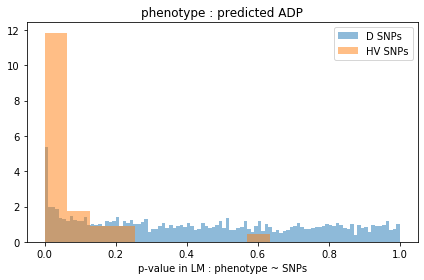

In [24]:
all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    
    all_hits = list(set(all_d_hits + significant_SNPs[pheno]))
    #all_hits = significant_SNPs[pheno]
    lm = LinearRegression().fit(X_G_H[all_hits],adj_cov)
    pred = lm.predict(X_G_H[all_hits])
    
    lm_info = get_lm_info(X_G_H[all_hits],adj_cov,pred,lm)
    lm_info["P_alone"] = [pearsonr(X_G_H[s],adj_cov)[1] for s in all_hits]
    lm_info["SNP"] = all_hits
    lm_info.set_index("SNP",inplace=True)
    
    plt.figure()
    plt.hist(lm_info["P"],density=True,bins=100,alpha=.5,label="D SNPs")
    plt.hist(lm_info.loc[significant_SNPs[pheno],"P"],density=True,alpha=.5,label="HV SNPs")
    plt.xlabel("p-value in LM : phenotype ~ SNPs")
    plt.title("phenotype : predicted %s" % pheno)
    plt.legend()
    plt.tight_layout()

In [25]:
illustrate = pd.merge(gw.loc[gw.pheno == pheno],lm_info,left_on="SNP",right_index=True,how="inner")

In [26]:
S = X_G_H[significant_SNPs[pheno]].values
S = S - np.mean(S,axis=0)
corr = np.abs((S.T @ S) / (S.shape[0]**2))
np.fill_diagonal(corr, 0.)

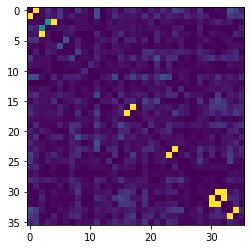

In [27]:
plt.imshow(corr,vmin=0.,vmax=.000001)
corr_snps = np.where(corr > .000001)[0]

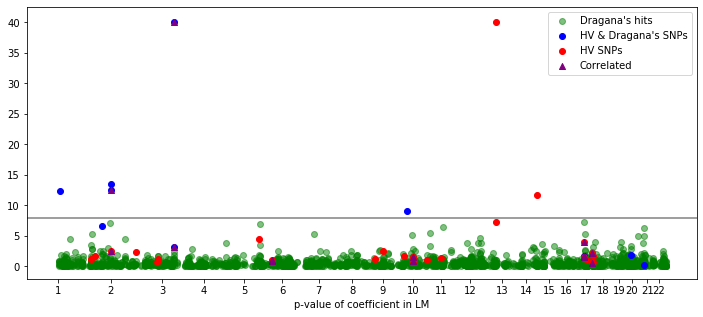

In [28]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
is_corr = illustrate.SNP.isin([significant_SNPs[pheno][i] for i in corr_snps])
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],-np.log10(illustrate.loc[~is_HV,"P_y"]),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"],-np.log10(illustrate.loc[is_HV & is_D,"P_y"]),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],-np.log10(illustrate.loc[is_HV & ~is_D,"P_y"]),c="red",alpha=1,label="HV SNPs")
plt.scatter(illustrate.loc[is_HV & is_corr,"POS"],-np.log10(illustrate.loc[is_HV & is_corr,"P_y"]),c="purple",marker="^",alpha=1,label="Correlated")
plt.axhline(8,c="grey")
plt.xlabel("p-value of coefficient in LM")
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

/home/hv270/.local/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


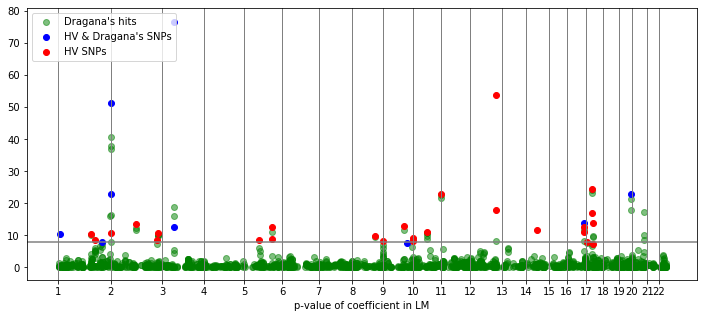

In [29]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],-np.log10(illustrate.loc[~is_HV,"P_alone"]),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"],-np.log10(illustrate.loc[is_HV & is_D,"P_alone"]),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],-np.log10(illustrate.loc[is_HV & ~is_D,"P_alone"]),c="red",alpha=1,label="HV SNPs")

plt.axhline(8,c="grey")
plt.xlabel("p-value of coefficient in LM")
for c in [gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)]:
    plt.axvline(c,color="grey",lw=1)
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

# Look in Dragana's GWAS

In [30]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["SNP"].isin(all_significant_SNPs)]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [31]:
sysmex_pheno = ~dgw.pivot_table(aggfunc="first",index="SNP",columns="Associated Blood Index",values=["Gene"])["Gene"].isnull()

In [32]:
genes = dgw.groupby("SNP")[["Gene"]].first()
genes

,Gene
SNP,
rs11121529,KIF1B
rs12445050,PLCG2
rs1339847,TRIM58
rs1354034,ARHGEF3
rs1654425,GP6
rs1768584,TMCC2
rs3215853,DOCK8
rs415064,TUBB1
rs56043070,GCSAML


In [33]:
sysmex_pheno["Dragana GWAS traits"] = ""
for c in sysmex_pheno.columns:
    if c == "Dragana GWAS traits": continue
    sysmex_pheno.loc[sysmex_pheno[c],"Dragana GWAS traits"] += "%s " % c

In [34]:
recap = pd.merge(recap,sysmex_pheno[["Dragana GWAS traits"]],how="left",left_index=True,right_index=True).fillna("")

In [35]:
import myvariant
mv = myvariant.MyVariantInfo()

gene_names = {}
to_query = recap.index.tolist()
a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)

for i in range(len(a)):
    q = a[i]["query"]
    try:
        gene = a[i]["cadd"]["gene"]["genename"]
    except:
        try:
            gene = a[i]["dbsnp"]["gene"]["symbol"]
        except:
            try:
                gene = a[i]["wellderly"]["genename"]
            except:
                try:
                    gene = a[i]["snpeff"]["ann"]["genename"]
                except:
                    try:
                        gene = a[i]["snpeff"]["ann"][0]["genename"]
                    except:
                        if q == "rs111763415":
                            gene = "SUFU"
                        else:
                            gene = "not found"
    if q in gene_names:
        gene_names[q].append(gene)
    else:
        gene_names[q] = [gene]

for q in gene_names:
    recap.loc[q,"genes"] = ", ".join(list(set(gene_names[q])))

querying 1-36...done.
Finished.
14 input query terms found dup hits:
	[('rs415064', 2), ('rs58088508', 2), ('rs7207182', 3), ('rs61751937', 2), ('rs12250755', 2), ('rs165
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [52]:
# for gene ontology
for gene in recap.genes.unique().tolist():
    print(gene.split("-")[0])

WDR66
LOC646548
TUBB1
TAOK1
PEAR1
ODF3
PLCG2
SLFN12L
SLC35D2
RALB
TMCC2
TRIM58
P2RX1
SVEP1
SETD1B
LOC101927824, RP11
DOCK10
GP6
NUFIP2
JMJD1C
GCSAML
LOC102477328
DNM3
ATG9A
SLC22A4
DOCK8
LOC101927824
ARHGEF3
PDLIM4
ZFPM2
AP2B1
OR11L1
KIF1B


In [39]:
recap.sort_values(["CHR","BP"])

,causal_ADP,BETA_ADP,P_ADP,A1FREQ,CHR,BP,Dragana GWAS traits,genes
rs11121529,True,0.088575,9.400000e-14,0.882618,1,10271688,MONO# MPV PLT#,KIF1B
rs12566888,True,0.094093,2.400000e-10,0.910487,1,156869047,,PEAR1
rs2180748,True,-0.054315,2.400000e-09,0.415776,1,171947018,,DNM3
rs1768584,True,-0.053530,7.800000e-10,0.621136,1,205240145,MPV PLT#,TMCC2
rs56043070,True,-0.164096,5.100000e-26,0.926692,1,247719769,HLSR# MPV MSCV PCT PDW PLT# RET# RET%,GCSAML
rs60726644,True,-0.079342,1.500000e-12,0.848839,1,248010949,,OR11L1-TRIM58
rs1339847,True,-0.208683,5.400000e-60,0.889817,1,248039294,HLSR# HLSR% MPV PDW RET# RET%,TRIM58
rs6739106,True,0.073190,7.000000e-18,0.304309,2,121053244,,RALB
rs79013471,True,-0.088241,1.800000e-09,0.908339,2,220096122,,ATG9A
rs10164672,True,-0.103094,3.200000e-12,0.922027,2,225751613,,DOCK10


In [40]:
recap.to_csv("/home/hv270/sysmex2pf/recap_%s.csv" % tag)

NameError: name 'recap' is not defined

# Manhattan plot

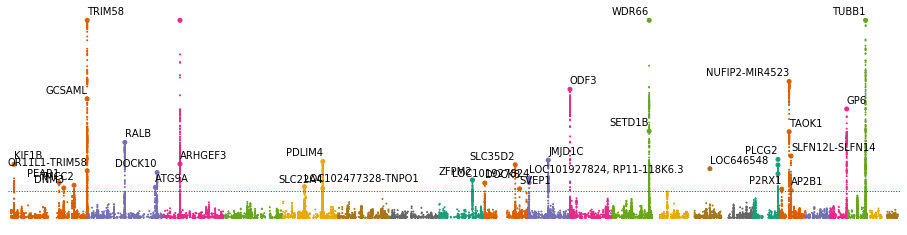

In [42]:
cmap = plt.get_cmap("Dark2")
for c in pheno_cols:
    g = gw_.loc[gw_.pheno == c]
    g.P = np.clip(g.P,a_min=1e-40,a_max=1)
    plt.figure(figsize=(16,4))
    plt.scatter(g.POS,-np.log10(g.P),c=cmap(g.CHR % 8),s=1 + 15*g.SNP.isin(significant_SNPs[c]))
    plt.xticks([g.loc[g.CHR == ch,"POS"].min() for ch in range(1,23)],[str(ch) for ch in range(1,23)])
    plt.axhline(8,c="red",ls=":",lw=1)
    written_genes = []
    for i, snp in enumerate(recap.loc[recap["causal_%s" % c]].index):
        pos = g.loc[g.SNP == snp,"POS"] #+ (i % 2)*1e7 - 5e6
        height = 1 - np.log10(g.loc[g.SNP == snp,"P"])
        gene = recap.loc[snp,"genes"]
        if gene not in written_genes:
            plt.text(pos, height,gene,ha="right" if i % 2 == 0 else "left")
            written_genes.append(gene)
    plt.axis("off")
    plt.xlim((g.POS.min()-1e7,g.POS.max() + 1e7))

# Compute score

In [43]:
causal_snps = {}
for c in pheno_cols:
    causal_path = "%s/conditional_analysis/causal_SNPs_%s_%s.txt" % (export_folder,tag,c)
    causal_snps[c] = [c[:-1] for c in open(causal_path,"r").readlines()]

In [44]:
good = {}
for c in pheno_cols:
    good[c] = gw.loc[(gw.pheno == c) & (gw.SNP.isin(causal_snps[c]))]

In [45]:
first_pheno = pheno_cols[0]
betas = good[first_pheno][["SNP","BETA"]].rename(columns={"BETA":first_pheno})
for c in pheno_cols[1:]:
    betas = pd.merge(betas,good[c][["SNP","BETA"]].rename(columns={"BETA":c}),
                     left_on="SNP",right_on="SNP",how="outer")
betas = pd.merge(betas,gw.loc[gw.pheno == "ADP",["SNP","ALLELE1"]],left_on="SNP",right_on="SNP",how="left")
betas = betas[["SNP","ALLELE1"] + pheno_cols]
betas.fillna(0,inplace=True)
assert betas.shape[0] == betas.SNP.nunique()

In [46]:
good_chroms = []
for c in good:
    good_chroms += good[c].CHR.unique().tolist()
good_chroms = list(set(good_chroms))
print(good_chroms)

[1, 2, 3, 5, 8, 9, 10, 11, 12, 14, 16, 17, 19, 20]


In [47]:
betas.head()

,SNP,ALLELE1,ADP
0,rs11121529,C,0.088575
1,rs12566888,G,0.094093
2,rs2180748,T,-0.054315
3,rs1768584,A,-0.053530
4,rs56043070,G,-0.164096


In [48]:
if not os.path.exists("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag)):
    os.mkdir("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag))

In [49]:
betas_path = "%s/Genetic_score_Sysmex_traits/betas.csv" % (export_folder)
betas.to_csv(betas_path,
            sep="\t",index=False)

n_splits = 16

all_causal_path = "%s/conditional_analysis/causal_SNPs_%s_all.txt" % (export_folder,tag)

for chrom in good_chroms:
    command = "/home/hv270/Plink2/plink2"
    command += " --bgen /rds/project/wja24/rds-wja24-uk-biobank-gen/bgen/ukb_imp_chr%s_v3.bgen" % chrom
    command += " --sample /rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/sample/ukb13745_imp_chr%s_v3_s487378.sample" % chrom
    #command += " --extract %s" % causal_snps_path
    command += " --keep %s" % EUR_path
    command += " --extract %s" % all_causal_path
    command += " --score %s header-read" % betas_path
    if len(pheno_cols) > 1:
        command += " --score-col-nums 3-%d" % (2 + len(pheno_cols))
    else:
        command += " --score-col-nums 3"
    command += " --out %s/Genetic_score_Sysmex_traits/%s/good_score_chr%s" % (export_folder,tag,chrom)
    command += " --threads %d" % n_splits

    f_name = "/home/hv270/interval_slurm_calls/call_gs_chr_%s_%s.sh" % (chrom,tag)
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J chr%s\n" % (chrom))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    f.write("#SBATCH --time=8:30:00\n")
    f.write("#SBATCH -p skylake-himem\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s_%s.out\n" % ("GS",tag,chrom))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % (chrom))
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting 1
Submitting 2
Submitting 3
Submitting 5
Submitting 8
Submitting 9
Submitting 10
Submitting 11
Submitting 12
Submitting 14
Submitting 16
Submitting 17
Submitting 19
Submitting 20
